<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/bam098_plant_pathology_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pathology

Kaggle Competition: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data

In [ ]:
! pip uninstall fastai -y
! pip install fastai

Uninstalling fastai-2.1.8:
  Successfully uninstalled fastai-2.1.8
  Using cached https://files.pythonhosted.org/packages/ff/53/da994550c0dd2962351fd694694e553afe0c9516c02251586790f830430b/fastai-2.1.8-py3-none-any.whl


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import platform
import fastai
from fastai.vision.all import *
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata
import torch
import torchvision
import pandas as pd

print('python version:      {}'.format(platform.python_version()))
print('fastai version:      {}'.format(fastai.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('scipy version:       {}'.format(scipy.__version__))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('pandas version:      {}'.format(pd.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
fastai version:      2.1.8
sklearn version:     0.22.2.post1
scipy version:       1.4.1
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
pandas version:      1.1.4
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
random_seed = 42

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
data_dir = Path('/content/gdrive/MyDrive/fastai/data/plant-pathology')
img_dir  = data_dir / 'images'

img_size = 224
bs = 32
arch = resnet18
#lr = 1.9e-4
lr = 3e-3

In [ ]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
#torch.set_deterministic(True)

## Data

In [ ]:
data_dir.ls()

(#4) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/train.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/test.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/sample_submission.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images')]

In [ ]:
img_dir.ls()

(#3642) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1702.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1712.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_171.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1710.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1738.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1736.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1771.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1770.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1765.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1756.jpg')...]

### Explore Data

In [ ]:
train_df = pd.read_csv(data_dir/'train.csv'); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


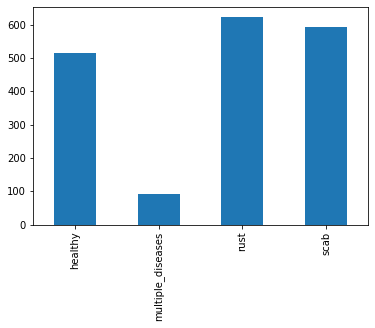

In [ ]:
train_df[labels].sum().plot(kind='bar')

In [ ]:
train_df['label'] = train_df[labels].idxmax(1); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [ ]:
train_df['label'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

In [ ]:
test_df = pd.read_csv(data_dir/'test.csv')

## Metric

In [ ]:
# reference: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def comp_metric(preds, targs, labels=range(len(labels))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

## Training

Reference: https://www.kaggle.com/hamonk/plant-pathology-fastai

In [ ]:
skf = StratifiedKFold(shuffle=True)

In [ ]:
train_df['fold'] = -1
for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df['label'])):
    print(train_index.shape, val_index.shape)
    train_df.loc[val_index, 'fold'] = i

(1456,) (365,)
(1457,) (364,)
(1457,) (364,)
(1457,) (364,)
(1457,) (364,)


In [ ]:
train_df.to_csv('my_train_with_folds.csv', index=False)

In [ ]:
for fold in range(0,5):
    print(fold)

    db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      splitter=IndexSplitter(train_df[train_df['fold'] == fold].index),
                      get_x=ColReader('image_id', pref=img_dir, suff='.jpg'),
                      get_y=ColReader('label'),
                      item_tfms=Resize(img_size),
                      batch_tfms=aug_transforms(size=img_size, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True))

    dls = db.dataloaders(source=train_df, bs=bs)

    learn = cnn_learner(dls, 
                        arch, 
                        loss_func=CrossEntropyLossFlat(), 
                        metrics=[accuracy, AccumMetric(comp_metric, flatten=False)],
                        cbs=CSVLogger(f'history_{fold}'))
    
    learn.fine_tune(5, base_lr=3e-3)
    learn.save(f'model_{fold}')
    
    tst_dl = dls.test_dl(test_df)
    res = learn.get_preds(dl=tst_dl)
    
    cols=['healthy', 'multiple_diseases', 'rust', 'scab']
    pd.concat([test_df, pd.DataFrame(res[0], columns=cols)], axis=1).to_csv(f'submission_{fold}.csv', index=False)

0


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.253834,0.619110,0.854795,0.889426,01:17


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.641486,0.494287,0.873973,0.925487,01:20
1,0.534304,0.289175,0.923288,0.926039,01:19
2,0.410893,0.293454,0.920548,0.943160,01:19
3,0.342373,0.263479,0.931507,0.948797,01:19
4,0.294206,0.288528,0.920548,0.949009,01:19


1


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.295396,0.770800,0.804945,0.868096,01:16


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.643281,0.485434,0.859890,0.899908,01:18
1,0.546422,0.382845,0.884615,0.905004,01:18
2,0.445075,0.313407,0.909341,0.913981,01:18
3,0.371008,0.305431,0.906593,0.920479,01:18
4,0.285219,0.282495,0.914835,0.919621,01:18


2


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.263441,0.691491,0.802198,0.881716,01:17


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.669550,0.449648,0.846154,0.902104,01:19
1,0.464206,0.410859,0.890110,0.904392,01:18
2,0.394241,0.333036,0.895604,0.906522,01:18
3,0.330881,0.306456,0.917582,0.924249,01:18
4,0.270782,0.314267,0.912088,0.922103,01:19


3


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.265444,0.715912,0.804945,0.867476,01:17


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.573740,0.387699,0.879121,0.884585,01:19
1,0.551430,0.342463,0.920330,0.901072,01:19
2,0.413328,0.298435,0.920330,0.931334,01:19
3,0.350811,0.263603,0.912088,0.932653,01:19
4,0.279730,0.230384,0.925824,0.934772,01:19


4


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.177524,0.919199,0.782967,0.879627,01:18


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.651181,0.538663,0.868132,0.911498,01:19
1,0.505356,0.388145,0.906593,0.920156,01:20
2,0.429507,0.315731,0.909341,0.915603,01:19
3,0.336530,0.348690,0.901099,0.935823,01:18
4,0.282233,0.279352,0.914835,0.938182,01:19


## Submission

In [ ]:
my_df = {}
for fold in range(0, 5):
    my_df[fold] = pd.read_csv(f'submission_{fold}.csv').set_index('image_id')

# for each target, for each fold, compute the rank of the solution
for x in ['healthy','multiple_diseases','rust','scab']:
    for fold in range(0, 5):
        my_df[fold][x] = rankdata(my_df[fold][x], method='min')

# sum the ranks in the 1st df
for x in ['healthy','multiple_diseases','rust','scab']:
    for fold in range(1, 5):
        my_df[0][x] += my_df[fold][x]

my_df[0].reset_index().to_csv('submission.csv', index=False)